# Bereinigung
Bisher haben Sie im Laufe dieser Vorlesung ausschließlich mit Daten gearbeitet, die bereits bereinigt waren. Neben der Datenbeschaffung wird die Bereinigung - je nach Datenquelle - einen großen Teil Ihrer Zeit bei der Arbeit mit den Daten einnehmen. In diesem Kapitel werden einige übliche Fehler in Datensätzen vorgestellt und ein möglicher Umgang vorgeschlagen.

## Inhaltsverzeichnis
- [Vorbereitung](#Vorbereitung)
- [Fehlende Einträge, Duplikate und Inkonsistenzen](#Fehlende-Einträge-Duplikate-und-Inkonsistenzen)
- [Null-, NaN- und leere Werte](#Null--NaN--und-leere-Werte)
- [Ausreißer](#Ausreißer)
- [Aggregation und Diskretisierung](#Aggregation-und-Diskretisierung)
- [Normalisierung](#Normalisierung)
- [Hinweise zum Datensatz](#Hinweise-zum-Datensatz)

## Vorbereitung
Importieren Sie zunächst Pandas, NumPy und zwei zusammenhängende Tabellen. Auf den ersten Blick mögen sie sich bis auf eine Spalte gleichen, dennoch stammt die erste aus dem Ihnen bereits bekannten Datensatz [Disney+ Movies and TV Shows](https://www.kaggle.com/code/werador/disney-data-analysis/data), während die zweite Tabelle aus Daten von [The Movie Database API](https://developers.themoviedb.org/3/getting-started) erstellt wurde.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df1 = pd.read_csv('disney_plus_titles1.csv')
df1.head(5)

In [ ]:
df2 = pd.read_csv('disney_plus_titles2.csv')
df2.head(5)

Verbinden Sie beide Tabellen mit einem Outer-Join anhand der Spalte `show_id`.

In [ ]:
df_joined = pd.merge(df1, df2, left_on='show_id', right_on='show_id', how='outer')
df_joined.head(5)

## Fehlende Einträge, Duplikate und Inkonsistenzen
Fehlende Werte können viele verschiedene Ursachen besitzen. Lücken in Zeitreihen könne zum Beispiel schon dann entstehen, wenn kurz die Energieversorgung oder die Internetanbindung eines Geräts ausfällt. Spätestens dann, wenn Sie Daten aus verschiedenen Quellen zusammenführen, werden Sie schnell feststellen, dass häufig keine der Quellen die absolute Wahrheit besitzt.

Betrachten Sie zunächst die Ausgaben der Funktion `describe()` und achten Sie auf Unterschiede.

In [ ]:
# `int` ausschließen, da sonst die Spalte `release_year` bevorzugt wird
df1.describe(exclude=int)

In [ ]:
# `float` ausschließen, da sonst die Spalte `budget` bevorzugt wird
df2.describe(exclude=float)

An den Reihen `count` und `unique` erkennen Sie, dass der zweite Datensatz doppelte Titel enthält. Jedes DataFrame besitzt eine Funktion `duplicated`, die als Parameter den Namen einer Spalte akzeptiert und eine Series zurückgibt, die genau an den Stellen `True` enthält, die doppelt vorkommenden Einträgen entsprechen. Mit dem Parameter `keep` können Sie beeinflussen, welche der doppelten Reihen beibehalten wird - mit `False` werden alle in die Ausgabe aufgenommen.

Das Ergebnis dieser Methode wird in der folgenden Zelle zur Filterung verwendet. Nach der Ausführung werden alle Reihen angezeigt, die doppelte Titel enthalten. Sie selbst müssen entscheiden, ob sich das in Ihrer Weiterverarbeitung zum Problem entwickelt. Beachten Sie aber auch, dass sich die Reihen dennoch in anderen Spalten unterscheiden können. So existiert *The Muppets* als Serie wie auch als Film unter dem selben Titel.

In [ ]:
df2[df2.duplicated('title', keep=False)]

Der zweite Datensatz enthält weniger Einträge. Das legt die Vermutung nahe, dass in einer der beiden Tabellen Einträge fehlen. In der Join-Tabelle sind Einträge NaN, wenn kein Gegenstück anhand des Join-Kriteriums gefunden wurde. Die Suche nach fehlenden Werten bestimmt also genau die vermissten Einträge.

In [ ]:
df_joined[df_joined['type_x'].isna()]

In [ ]:
df_joined[df_joined['type_y'].isna()]

In `type_x` wurden keine fehlenden Einträge gefunden, in `type_y` dagegen sieben. Beachten Sie, dass Sie natürlich vorkommende NaN Einträge vor dem Join möglicherweise maskieren müssen.

Häufig gibt es keine zweite Tabelle, anhand derer Sie die Vollständigkeit prüfen können. Im Falle einer fortlaufend nummerierten Spalte wie `show_id` können Sie jedoch diese verwenden. Auch bei Datumsangaben lassen sich Lücken auf einfache Art und Weise finden.

Zuletzt unterscheidet sich der Eintrag `top` bezüglich des Titels. (Laut Dokumentation der Funktion `describe` wird die Ausgabe beliebig gewählt, falls mehrere Werte mit der gleichen, maximalen Häufigkeit vorkommen.) Nun werden also in der Join-Tabelle Einträge gesucht, in denen sich der Titel unterscheidet.

In [ ]:
df_joined[df_joined['title_x'] != df_joined['title_y']].head(5)

Sie sehen bereits, dass sich viele Angebote nur hinsichtlich der Groß- und Kleinschreibung oder durch ein Präfix unterscheiden. Mit der Funktion `apply` können Sie beliebig komplexe Vergleichsfunktionen implementieren und solche Fälle abfangen.

In [ ]:
def compare(row):
    x, y = row['title_x'], row['title_y']
    if np.nan in (x, y):
        return True

    x, y = x.lower(), y.lower()
    return x != y and not x.endswith(y)

df_joined[df_joined.apply(compare, axis=1)].head(5)

Auch bei Spalten, die nicht schon mit der `describe` Funktion auffallen, lohnt gelegentlich eine Prüfung.

In [ ]:
df_joined[df_joined['type_x'] != df_joined['type_y']].head(5)

Auch dabei ergeben sich Widersprüche. Wie Sie mit diesen umgehen, ist stark vom zu bearbeiteten Problem und der Vertrauenswürdigkeit der Daten abhängig. Vielleicht kennen Sie einige der Produktionen und können selbst beurteilen, welcher Datensatz zuverlässiger erscheint. Falls nicht, müssen Sie wohl einen Experten mit Domänenwissen hinzuziehen.

## Null-, NaN- und leere Werte
NaN wird immer dann von Pandas eingesetzt, wenn ein Wert nicht vorhanden ist. In der Spalte `budget` haben Sie diese vermutlich schon bemerkt. Wie Sie mit NaN umgehen, hängt dabei ganz von Ihrer gewählten Zielstellung ab, Sie sollten sich aber bewusst sein, welche Auswirkungen auf die Berechnungen entstehen.

Die folgende Zelle berechnet den Durchschnitt aller Budgets in Millionen US-Dollar.

In [ ]:
df2['budget'].mean() // 1_000_000

Für den nachfolgenden Wert wurden mit der Funktion `fillna` alle NaN Werte durch $0$ ersetzt. Da Pandas alle NaN Werte bei der Verwendung von Aggregationsfunktionen ignoriert, sinkt der Durchschnitt nach diesem Schritt, da deutlich mehr $0$-Werte als zuvor enthalten sind und gleichzeitig die Anzahl aller verwendeten Werte steigt.

In [ ]:
df2['budget'].fillna(0).mean() // 1_000_000

Je nach Fragestellung können jedoch auch spezielle Werte außer None und NaN das Fehlen von Informationen markieren. Um dies zu erkennen, benötigen Sie jedoch semantisches Wissen.

Im Datensatz beinhaltet die Spalte `budget` immer NaN, wenn die Zeile eine Serie enthält. Bei Filmen dagegen ist NaN nicht enthalten, stattdessen sind einige Produktionen mit einem Budget von $0$ USD aufgelistet. Ein Film ohne Budget kann aber natürlich nicht produziert werden, weshalb davon auszugehen ist, dass es sich auch dabei um einen fehlenden Wert handelt. Ebenfalls beliebt sind Zeichenketten, die entweder leer sind oder *None* oder *null* als Wort enthalten.

Mit der Funktion `replace` können Sie auch spezielle Werte mit NaN ersetzen, um sie bei der Berechnung auszunehmen. Der Durchschnitt steigt dadurch wieder.

In [ ]:
df2['budget'].replace(0, np.nan).mean() // 1_000_000

## Ausreißer
Pandas stellt verschiedene Funktionen bereit, um Ausreißer in Daten zu erkennen. Betrachten Sie zunächst ein Histogramm, um einen Überblick zu bekommen.

In [ ]:
budget = df2['budget'].replace(0, np.nan)
budget.hist(bins=200, figsize=(10, 5))

Die Verteilung lässt vermuten, dass es sich bei Filmen mit einem Budget von mehr als $250$ Millionen USD möglicherweise um Ausreißer handelt. Diese Filme kommen nur noch vereinzelt vor und könnten somit fehlerhafte Werte darstellen. In kleinen Datensätzen kann man diese nun händisch prüfen. Die folgende Zelle gibt alle Filme aus, die weiter als zwei Standardabweichungen vom Mittelwert entfernt liegen.

In [ ]:
df2[budget > (budget.mean() + 2 * budget.std())]

## Aggregation und Diskretisierung
Aggregation und Diskretisierung dienen der Erhöhung des Abstraktionslevels bei gleichzeitiger Reduzierung der Datenmenge. Beide Verfahren sind nur mit Wissen über die Daten und einer genauen Zielvorstellung möglich. Aggregationen werden in Pandas mit der Funktion `groupby` durchgeführt. Damit lassen sich zum Beispiel die verwendeten Budgets jahrzehnteweise zusammenfassen.

In [ ]:
dfc = df_joined.copy()

dfc['budget'] = dfc['budget'].replace(0, np.nan)
dfc['release_decade'] = dfc['release_year'] // 10 * 10

dfc.groupby('release_decade')['budget'].mean()

Bei einer Diskretisierung kann dagegen die Funktion `cut` behilflich sein.

In [ ]:
dfc = df_joined.copy()

dfc['budget'] = pd.cut(dfc['budget'], 3, labels=['wenig', 'mittel', 'viel'])

dfc

## Normalisierung
Für einfaches Rechnen, das Vermeiden von Missverständnissen oder auf Grund von Anforderungen, die Algorithmen an ihre Eingabedaten stellen, ist es häufig notwendig, Daten zu normalisieren.

Denken Sie zum Beispiel daran, Währungen korrekt in eine gemeinsame, vergleichbare Basis umzurechnen, (internationale) Datumsformate richtig zu interpretieren und Zeitzonen zu beachten. Aber auch über einfache Umrechnungen hinaus existieren Sachverhalte, die Ergebnisse verfälschen können: Groß- und Kleinschreibung muss manchmal, wie sie weiter oben bereits gesehen haben, ignoriert werden. Ebenfalls in unserem Datensatz enthalten sind Angaben in einer Währung über einen langen Zeitraum, welche nicht kaufkraftbereinigt und kaum wenig vergleichbar sind.

Normalisierung beschäftigt sich aber auch mit der Transformation hinsichtlich der Bezugsskalen. Möchten Sie beispielsweise eine Spalte im Intervall $[0, 1]$ abbilden, wie es für verschiedene Algorithmen des Clusterings und der Klassifikation empfehlenswert ist, genügt die folgende Abbildung.

$$
budget_{[0,1]} = \dfrac{budget_{[a,b]} - a}{b - a}
$$

Dabei ist $a$ das Minimum und $b$ das Maximum aller Einträge. Natürlich dürfen nicht alle Einträge gleich groß sein, sodass $a \neq b$.

In [ ]:
dfc = df2.copy()

dfc['budget'] = dfc['budget'].replace(0, np.nan)
dfc['relative_budget'] = (dfc['budget'] - dfc['budget'].min()) / (dfc['budget'].max() - dfc['budget'].min())

dfc

## Hinweise zum Datensatz
Ein Teil der Ihnen zur Verfügung gestellten Daten wurden mit Hilfe der TMDb API erzeugt. Die Verwendung wird weder von TMDb unterstützt noch zertifiziert.

[![TMDb Logo]( 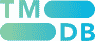)](https://developers.themoviedb.org/3)